In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
import pandas as pd
import numpy as np
from utils.predictiveNet import PredictiveNet
from utils.agent import RandomActionAgent
import itertools
import torch
import random
from utils.env import make_env
from utils.general import saveFig
from utils.figures import TrainingFigure
import matplotlib.pyplot as plt
from analysis.SpatialTuningAnalysis import SpatialTuningAnalysis, makeUntrainedNet
from analysis.OfflineTrajectoryAnalysis import OfflineTrajectoryAnalysis
from analysis.DiffusionReplayAnalysis import DiffusionReplayAnalysis
from copy import deepcopy



In [3]:
savefolder = 'Figures/S4_FeedForwardEtc/'

In [4]:
#Example Net
netname = 'AutoencoderFFPred_LN'
netfolder = '/Autoencoder_sparse_panel/'
exseed = 102
predictiveNet = PredictiveNet.loadNet(netfolder+netname+'-Onehot-s'+str(exseed))

Net Loaded from pathname


In [5]:
predictiveNet.trainArgs

Namespace(actenc='Onehot', bias_lr=0.1, bptttrunc=100000000.0, contin=False, dropout=0.15, env='MiniGrid-LRoom-18x18-v0', hiddensize=500, identityInit=False, load_env=-1, loadfolder='', lr=0.002, namext='Onehot', noisemean=0, noisestd=0.03, ntimescale=2.0, numepochs=80, numtrials=1000, pRNNtype='AutoencoderFFPred_LN', saveTrainData=False, savefolder='Autoencoder_sparse_panel/', seed=102, seqdur=600, sparsity=0.5, trainBias=True, weight_decay=0.003)

In [6]:
env = predictiveNet.EnvLibrary[0]
agentname = 'RandomActionAgent'
action_probability = np.array([0.15,0.15,0.6,0.1,0,0,0])
agent = RandomActionAgent(env.action_space,action_probability)
place_fields, SI, decoder = predictiveNet.calculateSpatialRepresentation(env,agent,
                                             trainDecoder=True, trainHDDecoder = True)

Training Decoder on cuda...
loss: 5.857942 [    0\ 5000]
loss: 2.171947 [  500\ 5000]
loss: 1.619619 [ 1000\ 5000]
loss: 1.357757 [ 1500\ 5000]
loss: 1.200020 [ 2000\ 5000]
loss: 1.096440 [ 2500\ 5000]
loss: 1.028534 [ 3000\ 5000]
loss: 0.955219 [ 3500\ 5000]
loss: 0.910251 [ 4000\ 5000]
loss: 0.886165 [ 4500\ 5000]
loss: 0.866788 [ 4999\ 5000]
Training Complete. Back to the cpu
Training Decoder on cuda...
loss: 1.397789 [    0\ 5000]
loss: 1.162692 [  500\ 5000]
loss: 1.146734 [ 1000\ 5000]
loss: 1.139378 [ 1500\ 5000]
loss: 1.116709 [ 2000\ 5000]
loss: 1.116017 [ 2500\ 5000]
loss: 1.108717 [ 3000\ 5000]
loss: 1.114889 [ 3500\ 5000]
loss: 1.109910 [ 4000\ 5000]
loss: 1.102292 [ 4500\ 5000]
loss: 1.106230 [ 4999\ 5000]
Training Complete. Back to the cpu


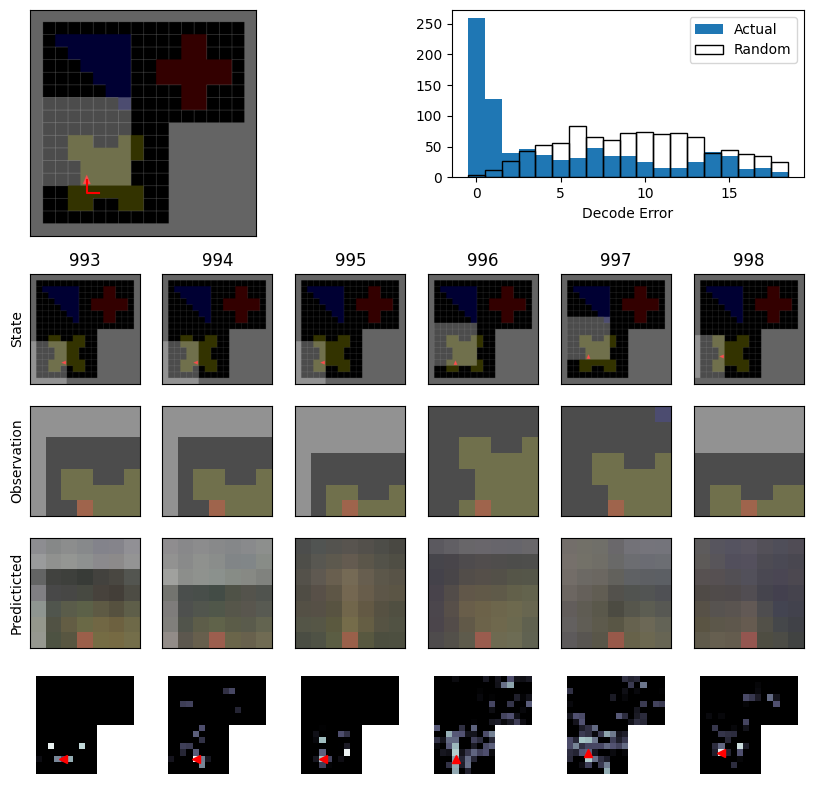

In [7]:
#[11, 26, 26, 39, 46, 52, 63, 69, 74]
seed = 69 #just happened to be a trajectory that got included walls and the view was fully in the environment o_0
env.seed(seed)
predictiveNet.calculateDecodingPerformance(env,agent,decoder,
                                            savename=netname, savefolder=savefolder,
                                          trajectoryWindow=5, seed=seed,
                                          timesteps=1000)

In [8]:
STA = SpatialTuningAnalysis(predictiveNet,inputControl=True, untrainedControl=True)

Getting Tuning Curves for Input Units
Running Untrained Control


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]


Running WAKE


/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:150: RuntimeWarning: divide by zero encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:150: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Running WAKE
Calculating EV_s
Calculating EV_s for input control


In [9]:
_, _, untrained_decoder = STA.pNControl.calculateSpatialRepresentation(env,agent,
                                             trainDecoder=True, trainHDDecoder = False)

/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]


Training Decoder on cuda...
loss: 5.836401 [    0\ 5000]
loss: 2.900117 [  500\ 5000]
loss: 2.373446 [ 1000\ 5000]
loss: 2.114271 [ 1500\ 5000]
loss: 1.947522 [ 2000\ 5000]
loss: 1.817334 [ 2500\ 5000]
loss: 1.725205 [ 3000\ 5000]
loss: 1.679481 [ 3500\ 5000]
loss: 1.625000 [ 4000\ 5000]
loss: 1.566038 [ 4500\ 5000]
loss: 1.539918 [ 4999\ 5000]
Training Complete. Back to the cpu


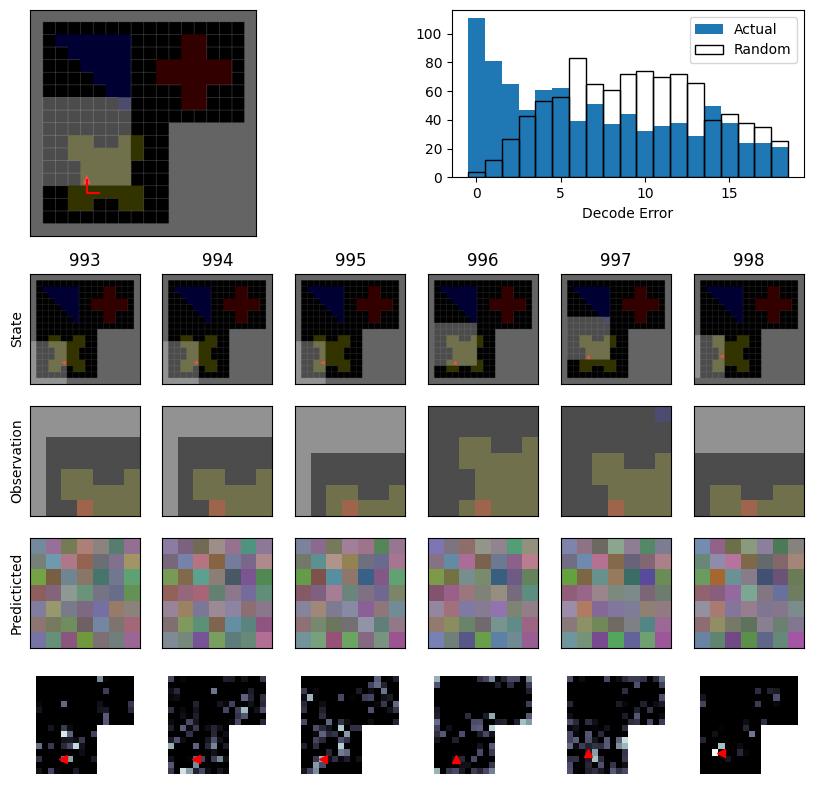

In [10]:
env.seed(seed)
STA.pNControl.calculateDecodingPerformance(env,agent,untrained_decoder,
                                            savename='untrained', savefolder=savefolder,
                                          trajectoryWindow=5,
                                          timesteps=1000, seed=seed)

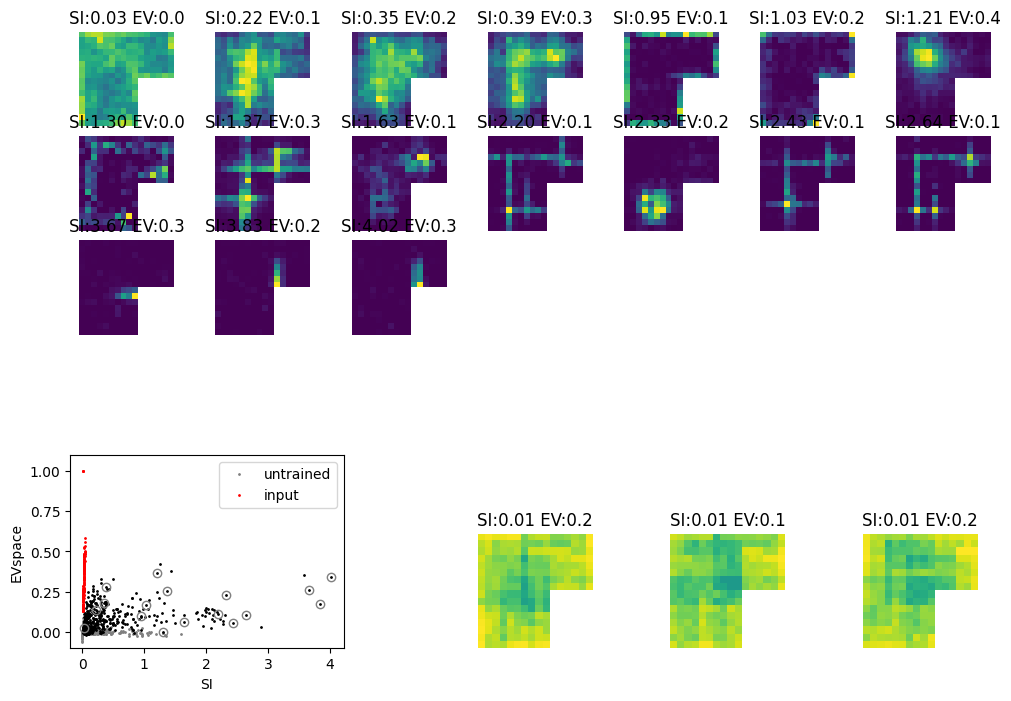

In [11]:
STA.SpatialTuningFigure(netname=netname,savefolder=savefolder,
                       exgrid=5, seed=3)

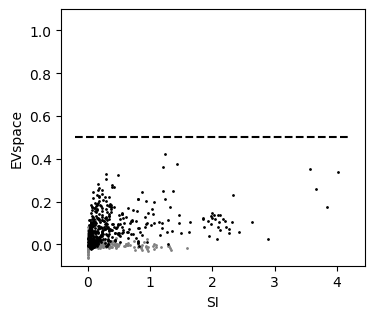

In [13]:
#5,6,8,15
STA.TCExamplesFigure(netname,savefolder, seed=15)

In [16]:
nettypes = ['AutoencoderPred_LN','AutoencoderFFPred_LN']
hpidx = ['Onehot']
seeds = ['100','101','102','103','104','105']
#lr = [1e-4,1.5e-4,3e-4,5.5e-4,1e-3,1.5e-3,3e-3]
netprops = itertools.product(*[nettypes,['-'],hpidx,['-s'],seeds])
netprops = list(netprops)
netnames = [''.join(name) for name in netprops]
nettype = [name[0] for name in netprops]
#netmask = [name[4] for name in netprops]
#netk = [int(name[2]) for name in netprops]

netfolder = '/Autoencoder_sparse_panel/'

analysisFrame = pd.DataFrame(data={'filename':netnames, 'type':nettype, 'netfolder':netfolder})

In [36]:
#netfolder = '/hyperparm_panel_masked/'
def loadNet(row):
    netfolder = row.netfolder
    try:
        net = PredictiveNet.loadNet(netfolder+row['filename'],suppressText=True)
        return net
    except:
        print(f"{row['filename']} does not exist")
        #net = PredictiveNet
        

analysisFrame['net'] = analysisFrame.apply(loadNet, axis = 1)


In [18]:
#analysisFrame['net'][0].trainArgs
def getTrainParms(row):
    predictiveNet = row['net']
    lr = predictiveNet.trainArgs.lr
    seed = predictiveNet.trainArgs.seed
    weight_decay = predictiveNet.trainArgs.weight_decay
    bptttrunc = predictiveNet.trainArgs.bptttrunc
    seqdur = predictiveNet.trainArgs.seqdur
    dropp = predictiveNet.trainArgs.dropout
    ntimescale = predictiveNet.trainArgs.ntimescale
    nneurons = predictiveNet.trainArgs.hiddensize
    noisestd = predictiveNet.trainArgs.noisestd
    sparsity = predictiveNet.trainArgs.sparsity
    
    return lr,bptttrunc,seqdur,seed,dropp,ntimescale,weight_decay,nneurons,noisestd,sparsity
analysisFrame[['lr','bptt','seqdur','seed','dropp','ntimescale','weight_decay','nneurons','noisestd','sparsity']] = analysisFrame.apply(getTrainParms, axis = 1, result_type="expand")


In [94]:
#Calculate spatial info and decoding performance
def getSpatialRep(row):
    #predictiveNet = loadNet(row)
    predictiveNet = row['net']
    if predictiveNet == None:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    #predictiveNet= row.net
    #print(len(predictiveNet.TrainingSaver['sRSA'].values))
    try:
        SI = predictiveNet.TrainingSaver['SI'].values[-1]
        sRSA = predictiveNet.TrainingSaver['sRSA'].values[-1]

        EVs = predictiveNet.TrainingSaver['EVs'].values[-1]
        
        SWdist = predictiveNet.TrainingSaver['SWdist'].values[-1]
        finalLoss = predictiveNet.TrainingSaver['loss'].values[-1]
        logloss = np.log10(finalLoss)
        derror = predictiveNet.TrainingSaver['derror'].values[-1]
    except:
        SI = predictiveNet.TrainingSaver['SI']
        sRSA = predictiveNet.TrainingSaver['sRSA']

        EVs = predictiveNet.TrainingSaver['EVs']
        
        SWdist = predictiveNet.TrainingSaver['SWdist']
        finalLoss = predictiveNet.TrainingSaver['loss']
        logloss = np.log10(finalLoss)
        
        derror = predictiveNet.TrainingSaver['derror']
        
    meanSI = np.nanmean(SI)
    EVsp50 = np.nanmean(EVs>0.5)
    tunedSI = np.nanmean(SI[EVs>0.5])
    meanError = np.mean(derror)
    
    return SI, meanSI, sRSA, EVs, EVsp50, finalLoss, SWdist, tunedSI, derror, meanError,logloss
analysisFrame[['SI','meanSI','sRSA','EVs','EVs50','finalLoss','SWdist','tunedSI','derror','meanError','logloss']] = analysisFrame.apply(getSpatialRep, axis = 1, result_type="expand")

In [86]:
def replaceWithUntrained(row):
    untrained = makeUntrainedNet(row['net'], env, agent,
                                 decodeError=True, calculatesRSA = True)
    untrained.trainingEpoch(env, agent, 
                            sequence_duration=untrainedFrame.iloc[0].net.trainArgs.seqdur, 
                            num_trials=1)
    return untrained
untrainedFrame = deepcopy(analysisFrame)    
untrainedFrame['net'] = untrainedFrame.apply(replaceWithUntrained, axis=1)


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.919682 [    0\ 5000]
loss: 2.701057 [  500\ 5000]
loss: 2.071428 [ 1000\ 5000]
loss: 1.718100 [ 1500\ 5000]
loss: 1.554229 [ 2000\ 5000]
loss: 1.419081 [ 2500\ 5000]
loss: 1.339268 [ 3000\ 5000]
loss: 1.255937 [ 3500\ 5000]
loss: 1.197277 [ 4000\ 5000]
loss: 1.143996 [ 4500\ 5000]
loss: 1.133209 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.03, sparsity: 0.33, meanrate: 0.38 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.905534 [    0\ 5000]
loss: 2.490875 [  500\ 5000]
loss: 1.846357 [ 1000\ 5000]
loss: 1.514405 [ 1500\ 5000]
loss: 1.324635 [ 2000\ 5000]
loss: 1.196829 [ 2500\ 5000]
loss: 1.097999 [ 3000\ 5000]
loss: 1.043813 [ 3500\ 5000]
loss: 0.975728 [ 4000\ 5000]
loss: 0.934200 [ 4500\ 5000]
loss: 0.903718 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.032, sparsity: 0.34, meanrate: 0.39 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.907951 [    0\ 5000]
loss: 3.024070 [  500\ 5000]
loss: 2.388827 [ 1000\ 5000]
loss: 2.058595 [ 1500\ 5000]
loss: 1.848527 [ 2000\ 5000]
loss: 1.715076 [ 2500\ 5000]
loss: 1.618199 [ 3000\ 5000]
loss: 1.542036 [ 3500\ 5000]
loss: 1.469028 [ 4000\ 5000]
loss: 1.424754 [ 4500\ 5000]
loss: 1.405636 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.035, sparsity: 0.31, meanrate: 0.37 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.874328 [    0\ 5000]
loss: 2.711660 [  500\ 5000]
loss: 2.058469 [ 1000\ 5000]
loss: 1.743917 [ 1500\ 5000]
loss: 1.550748 [ 2000\ 5000]
loss: 1.409733 [ 2500\ 5000]
loss: 1.315036 [ 3000\ 5000]
loss: 1.242337 [ 3500\ 5000]
loss: 1.179804 [ 4000\ 5000]
loss: 1.141567 [ 4500\ 5000]
loss: 1.108218 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.036, sparsity: 0.33, meanrate: 0.38 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.875830 [    0\ 5000]
loss: 2.806769 [  500\ 5000]
loss: 2.157899 [ 1000\ 5000]
loss: 1.826678 [ 1500\ 5000]
loss: 1.619431 [ 2000\ 5000]
loss: 1.479818 [ 2500\ 5000]
loss: 1.392645 [ 3000\ 5000]
loss: 1.294596 [ 3500\ 5000]
loss: 1.240868 [ 4000\ 5000]
loss: 1.198599 [ 4500\ 5000]
loss: 1.152581 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.036, sparsity: 0.33, meanrate: 0.38 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.934911 [    0\ 5000]
loss: 2.593617 [  500\ 5000]
loss: 1.924294 [ 1000\ 5000]
loss: 1.601240 [ 1500\ 5000]
loss: 1.401976 [ 2000\ 5000]
loss: 1.246732 [ 2500\ 5000]
loss: 1.156519 [ 3000\ 5000]
loss: 1.076099 [ 3500\ 5000]
loss: 1.033557 [ 4000\ 5000]
loss: 0.982972 [ 4500\ 5000]
loss: 0.943684 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.031, sparsity: 0.33, meanrate: 0.38 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.868425 [    0\ 5000]
loss: 2.940092 [  500\ 5000]
loss: 2.408688 [ 1000\ 5000]
loss: 2.139726 [ 1500\ 5000]
loss: 1.950922 [ 2000\ 5000]
loss: 1.831912 [ 2500\ 5000]
loss: 1.751500 [ 3000\ 5000]
loss: 1.683639 [ 3500\ 5000]
loss: 1.625068 [ 4000\ 5000]
loss: 1.592864 [ 4500\ 5000]
loss: 1.546797 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.027, sparsity: 0.41, meanrate: 0.4 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.872193 [    0\ 5000]
loss: 2.926194 [  500\ 5000]
loss: 2.406341 [ 1000\ 5000]
loss: 2.136674 [ 1500\ 5000]
loss: 1.967246 [ 2000\ 5000]
loss: 1.855687 [ 2500\ 5000]
loss: 1.780894 [ 3000\ 5000]
loss: 1.708418 [ 3500\ 5000]
loss: 1.669748 [ 4000\ 5000]
loss: 1.642854 [ 4500\ 5000]
loss: 1.601706 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.034, sparsity: 0.43, meanrate: 0.4 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.859132 [    0\ 5000]
loss: 2.925731 [  500\ 5000]
loss: 2.384776 [ 1000\ 5000]
loss: 2.093688 [ 1500\ 5000]
loss: 1.926733 [ 2000\ 5000]
loss: 1.802621 [ 2500\ 5000]
loss: 1.721099 [ 3000\ 5000]
loss: 1.655125 [ 3500\ 5000]
loss: 1.603305 [ 4000\ 5000]
loss: 1.584931 [ 4500\ 5000]
loss: 1.545827 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.028, sparsity: 0.41, meanrate: 0.4 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.823388 [    0\ 5000]
loss: 2.953045 [  500\ 5000]
loss: 2.414947 [ 1000\ 5000]
loss: 2.156543 [ 1500\ 5000]
loss: 1.991437 [ 2000\ 5000]
loss: 1.880552 [ 2500\ 5000]
loss: 1.786660 [ 3000\ 5000]
loss: 1.722825 [ 3500\ 5000]
loss: 1.703616 [ 4000\ 5000]
loss: 1.643715 [ 4500\ 5000]
loss: 1.614314 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.028, sparsity: 0.42, meanrate: 0.4 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.816941 [    0\ 5000]
loss: 2.893621 [  500\ 5000]
loss: 2.376535 [ 1000\ 5000]
loss: 2.090106 [ 1500\ 5000]
loss: 1.927997 [ 2000\ 5000]
loss: 1.820825 [ 2500\ 5000]
loss: 1.737205 [ 3000\ 5000]
loss: 1.666844 [ 3500\ 5000]
loss: 1.597722 [ 4000\ 5000]
loss: 1.567015 [ 4500\ 5000]
loss: 1.526617 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.031, sparsity: 0.41, meanrate: 0.4 [    0\    1]
Epoch Complete. Back to the cpu


/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:340: RuntimeWarning: invalid value encountered in divide
  fxfr = fx / fr
/home/mila/d/daniel.levenstein/venvs/PredictiveReplay/lib/python3.8/site-packages/pynapple/process/tuning_curves.py:351: RuntimeWarning: invalid value encountered in divide
  SI = SI / fr[:, 0, 0]
/home/mila/d/daniel.levenstein/PredictiveReplay/analysis/SpatialTuningAnalysis.py:140: RuntimeWarning: invalid value encountered in divide
  EVSpace = 1 - np.var(spaceRemoved,axis=0) / (np.var(WAKE_h,axis=0))


Training Decoder on cuda...
loss: 5.842594 [    0\ 5000]
loss: 2.961074 [  500\ 5000]
loss: 2.443024 [ 1000\ 5000]
loss: 2.169036 [ 1500\ 5000]
loss: 1.984986 [ 2000\ 5000]
loss: 1.868653 [ 2500\ 5000]
loss: 1.801270 [ 3000\ 5000]
loss: 1.712001 [ 3500\ 5000]
loss: 1.691973 [ 4000\ 5000]
loss: 1.634046 [ 4500\ 5000]
loss: 1.606482 [ 4999\ 5000]
Training Complete. Back to the cpu
Training pRNN on cuda...
loss: 0.031, sparsity: 0.42, meanrate: 0.4 [    0\    1]
Epoch Complete. Back to the cpu


In [97]:
untrainedFrame.type = untrainedFrame.type+'un'
untrainedFrame[['SI','meanSI','sRSA','EVs','EVs50','finalLoss','SWdist','tunedSI','derror','meanError','logloss']] = untrainedFrame.apply(getSpatialRep, axis = 1, result_type="expand")

/tmp/ipykernel_3984865/719513615.py:31: RuntimeWarning: Mean of empty slice
  meanSI = np.nanmean(SI)


In [98]:
allFrame = pd.concat([analysisFrame,untrainedFrame])

<Figure size 640x480 with 0 Axes>

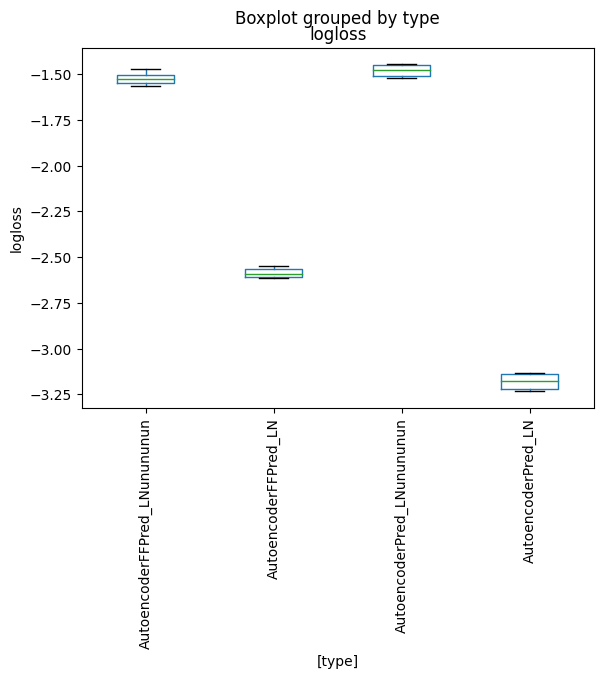

In [99]:
metrics = ['logloss']#,'meanSI','EVs50','meanError']
for metric in metrics:
    plt.figure()
    #ax=plt.subplot(3,3,1)
    allFrame.boxplot(column=metric,by=["type"],
                          rot=90,grid=False,showfliers=False,
                          positions=[2,1,4,3])
    plt.ylabel(metric)
    saveFig(plt.gcf(),'CompareNets'+metric,savefolder,
            filetype='pdf')
